In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from itertools import cycle

2025-10-21 23:07:44.434455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# --- 1. SETUP DATA PATHS AND PARAMETERS ---
train_dir = 'data/train'
validation_dir = 'data/validation'
test_dir = 'data/test'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
N_CLASSES = 4 

In [3]:
# --- 2. PREPROCESSING AND DATA AUGMENTATION ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
# --- 3. BUILD THE MODEL ARCHITECTURE ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- Print Model Summary ---
print("\n--- Model Architecture Summary ---")
model.summary()
print("\n")

I0000 00:00:1761102469.410124  118749 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



--- Model Architecture Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 21,138,500 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- 4. TWO-STAGE TRAINING AND FINE-TUNING ---
print("--- Starting Stage 1: Training the top layers ---")
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_stage1 = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("\n--- Starting Stage 2: Fine-tuning the model ---")
for layer in base_model.layers[10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_stage2 = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

--- Starting Stage 1: Training the top layers ---


/home/mandar-dhamale/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-10-21 23:07:51.742368: I external/local_xla/xla/service/service.cc:163] XLA service 0x78b68000e1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-21 23:07:51.742382: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-21 23:07:51.781855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-21 23:07:52.080873: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


  2/143 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.2656 - loss: 4.3247

I0000 00:00:1761102477.727225  121372 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - accuracy: 0.6887 - loss: 1.1577 - val_accuracy: 0.8554 - val_loss: 0.3896
Epoch 2/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7500 - loss: 0.6472

/home/mandar-dhamale/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7500 - loss: 0.6472 - val_accuracy: 0.8054 - val_loss: 0.4800
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.8128 - loss: 0.4968 - val_accuracy: 0.8482 - val_loss: 0.4182
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8750 - loss: 0.4847 - val_accuracy: 0.8357 - val_loss: 0.4852
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.8531 - loss: 0.3831 - val_accuracy: 0.8625 - val_loss: 0.3783
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8750 - loss: 0.5228 - val_accuracy: 0.8911 - val_loss: 0.3237
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.8593 - loss: 0.3738 - val_accuracy: 0.8625 - val_loss: 0.3764
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 0.0920 - val_accuracy: 0.8714 - val_loss: 0.3592
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.8943 - loss: 0.2668 - val_accurac

In [6]:
# --- 5. EVALUATE THE FINAL MODEL ---
print("\n--- Evaluating the final model on the test set ---")
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")


--- Evaluating the final model on the test set ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7812 - loss: 2.4156
Final Test Accuracy: 78.12%
Final Test Loss: 2.4156


In [7]:
# Generate predictions for the test set
test_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))
Y_pred_probs = model.predict(test_generator, steps=test_steps)
y_pred_labels = np.argmax(Y_pred_probs, axis=1)
y_true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# One-hot encode true labels for ROC/PR curve functions
y_true_one_hot = tf.keras.utils.to_categorical(y_true_labels, num_classes=N_CLASSES)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step



--- Classification Report ---
              precision    recall  f1-score   support

      glioma       0.95      0.37      0.53       100
  meningioma       0.68      0.98      0.80       115
    no_tumor       0.79      0.99      0.88       105
   pituitary       1.00      0.76      0.86        74

    accuracy                           0.79       394
   macro avg       0.85      0.77      0.77       394
weighted avg       0.84      0.79      0.76       394


--- Generating Confusion Matrix ---


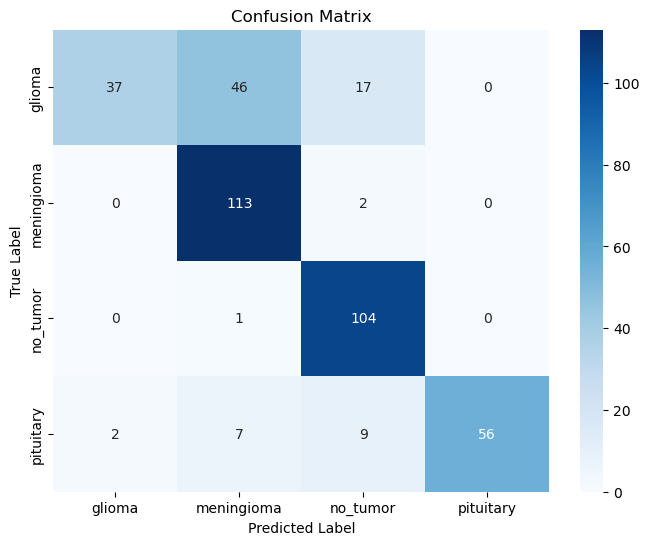


--- Generating AUC-ROC Curve ---


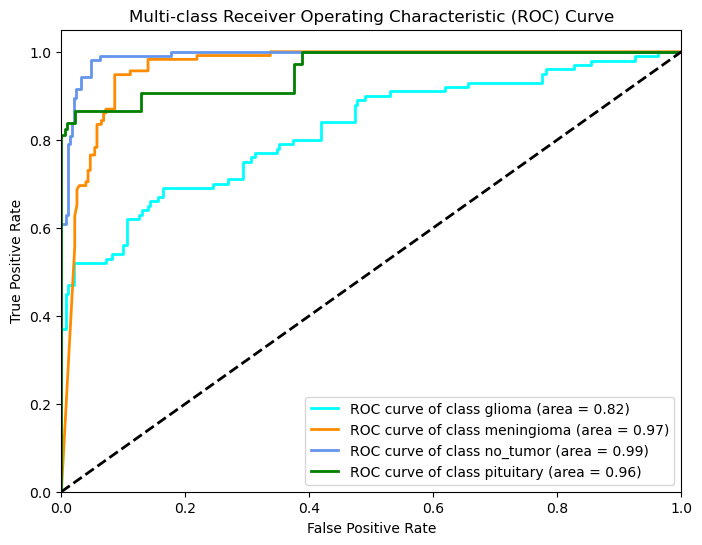


--- Generating Precision-Recall Curve ---


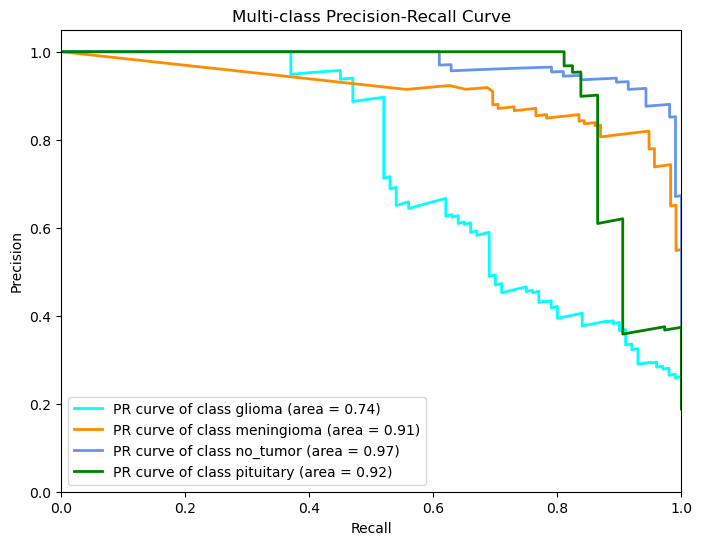

In [ ]:
# --- 6. DISPLAY PERFORMANCE METRICS  ---

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

# Confusion Matrix
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# AUC-ROC Curve
print("\n--- Generating AUC-ROC Curve ---")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(N_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('auc_roc_curve.png')
plt.show()


# Precision-Recall Curve
print("\n--- Generating Precision-Recall Curve ---")
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(N_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true_one_hot[:, i], Y_pred_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure(figsize=(8, 6))
for i, color in zip(range(N_CLASSES), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], pr_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png')
plt.show()